In [98]:
!pip install --quiet -r requirements.txt

In [99]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from shapely.geometry import shape
from libpysal.weights import Queen
from esda.moran import Moran
from spreg import ML_Lag, ML_Error
from geopy.distance import geodesic
os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

### Preliminary step
Using [Google Earth Engine Console](https://code.earthengine.google.com/), use the script `gee.js` to download the NDVI in 2023 in California.

### Zillow ZIP-level price data

Load the data from a local csv file into a pandas DataFrame. Keep only the latest price column (March 2023) and then rename some columns for the next merge process. After that keep only the rows with data about California.

In [100]:
# Download from: https://www.zillow.com/research/data/
zillow_df = pd.read_csv("data/Zip_Zhvi_AllHomes.csv")

# Pick latest column (e.g., March 2023)
zillow_df = zillow_df[['RegionName', 'State', 'Metro', '2023-03-31']].dropna()
zillow_df = zillow_df.rename(columns={
    'RegionName': 'zip',
    '2023-03-31': 'price_2023_03'
})
zillow_df['zip'] = zillow_df['zip'].astype(str).str.zfill(5)
zillow_df = zillow_df[zillow_df['State'] == 'CA']

### Load the NDVI file and merge
Load the csv file containing the NDVI for the California state (downloaded from Google Earth Engine) in a pandas DataFrame and rename the columns of the ZIP code and the NDVI value. 
Then merge the House Pricing DataFrame with the NDVI DataFrame using the "zip" column. For later analysis, save the resulting DataFrame into a csv file.

In [101]:
ndvi_df = pd.read_csv("data/NDVI_by_ZIP_CA_2023_Summer.csv")
ndvi_df = ndvi_df.rename(columns={
    'ZCTA5CE10': 'zip',
    'mean': 'ndvi'
})
ndvi_df['zip'] = ndvi_df['zip'].astype(str).str.zfill(5)

merged_df = pd.merge(zillow_df, ndvi_df, on='zip', how='inner')

merged_df = merged_df.dropna()

columns_to_drop = [
    'ALAND10', 'AWATER10', 'CLASSFP10', 'FUNCSTAT10',
    'GEOID10', 'INTPTLAT10', 'INTPTLON10', 'MTFCC10', 'system:index'
]
merged_df = merged_df.drop(columns=columns_to_drop)

### Add Median income in 2023 variable
In the Census [website](https://data.census.gov/), search for "Median Household Income" and add a filter for California ZIP codes. Then merge the two DataFrames, adding `median_income`.

In [102]:
# Download from https://data.census.gov/ 
acs_df = pd.read_csv("data/ACSST5Y2023.S1901-Data.csv")

# Extract ZIP code from NAME field
acs_df['zip'] = acs_df['NAME'].str.extract(r'ZCTA5 (\d{5})')

# Rename median income column
acs_df = acs_df.rename(columns={'S1901_C01_012E': 'median_income'})

# Keep only needed columns and drop rows with missing or invalid income
income_df = acs_df[['zip', 'median_income']].copy()
income_df = income_df[income_df['median_income'].str.replace(",", "").str.isnumeric()]
income_df['median_income'] = income_df['median_income'].str.replace(",", "").astype(float)

# Extract ZIP codes from merged_df (which are only from LA area)
la_zip_codes = merged_df['zip'].astype(str).str.zfill(5).unique()

# Filter income_df to keep only LA ZIPs
income_filtered_df = income_df[income_df['zip'].isin(la_zip_codes)].copy()

# Merge into merged_df
merged_df['zip'] = merged_df['zip'].astype(str).str.zfill(5)
merged_df = merged_df.merge(income_filtered_df, on='zip', how='left')

# Drop rows without median income (if any)
merged_df = merged_df.dropna(subset=['median_income'])

# Preview final merged result
merged_df.head()

,zip,State,Metro,price_2023_03,ndvi,.geo,median_income
0,90011,CA,"Los Angeles-Long Beach-Anaheim, CA",575299.946693,0.106211,"{""type"":""Polygon"",""coordinates"":[[[-118.243137...",53781.0
1,90650,CA,"Los Angeles-Long Beach-Anaheim, CA",688517.049025,0.136855,"{""type"":""Polygon"",""coordinates"":[[[-118.111611...",98709.0
2,91331,CA,"Los Angeles-Long Beach-Anaheim, CA",667445.089187,0.131292,"{""type"":""Polygon"",""coordinates"":[[[-118.450539...",82025.0
3,90044,CA,"Los Angeles-Long Beach-Anaheim, CA",624126.327848,0.114074,"{""type"":""Polygon"",""coordinates"":[[[-118.300191...",51433.0
4,92336,CA,"Riverside-San Bernardino-Ontario, CA",650964.436104,0.164758,"{""type"":""Polygon"",""coordinates"":[[[-117.405294...",121989.0


### Add other variables
Using the coordinates of the downtown of Los Angeles, the `distance_to_downtown` can be calculated and added to the DataFrame, along with the population `density` per ZIP code.

In [103]:
# Download from https://simplemaps.com/data/us-zips 
uszips_df = pd.read_csv("data/uszips.csv")

# Coordinates of Downtown Los Angeles
downtown_coords = (34.0522, -118.2437)

# Prepare ZIP coordinates for merge
uszips_df['zip'] = uszips_df['zip'].astype(str).str.zfill(5)
uszips_df = uszips_df[['zip', 'lat', 'lng', 'density']].dropna()

# Compute distance to downtown LA
uszips_df['distance_to_downtown'] = uszips_df.apply(
    lambda row: geodesic((row['lat'], row['lng']), downtown_coords).km, axis=1
)

merged_df['zip'] = merged_df['zip'].astype(str).str.zfill(5)
uszips_df['zip'] = uszips_df['zip'].astype(str).str.zfill(5)

merged_df = merged_df.merge(
    uszips_df[['zip', 'density', 'distance_to_downtown']],
    on='zip', how='left'
).dropna(subset=['density', 'distance_to_downtown'])

merged_df['log_price_2023_03'] = np.log(merged_df['price_2023_03'])

merged_df = merged_df[merged_df['Metro'] == 'Los Angeles-Long Beach-Anaheim, CA']

merged_df.head()

/tmp/ipykernel_7026/471542291.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  uszips_df = pd.read_csv("data/uszips.csv")


,zip,State,Metro,price_2023_03,ndvi,.geo,median_income,density,distance_to_downtown,log_price_2023_03
0,90011,CA,"Los Angeles-Long Beach-Anaheim, CA",575299.946693,0.106211,"{""type"":""Polygon"",""coordinates"":[[[-118.243137...",53781.0,9252.8,5.211134,13.262647
1,90650,CA,"Los Angeles-Long Beach-Anaheim, CA",688517.049025,0.136855,"{""type"":""Polygon"",""coordinates"":[[[-118.111611...",98709.0,3930.5,21.936491,13.442295
2,91331,CA,"Los Angeles-Long Beach-Anaheim, CA",667445.089187,0.131292,"{""type"":""Polygon"",""coordinates"":[[[-118.450539...",82025.0,4083.0,27.814586,13.411212
3,90044,CA,"Los Angeles-Long Beach-Anaheim, CA",624126.327848,0.114074,"{""type"":""Polygon"",""coordinates"":[[[-118.300191...",51433.0,7254.1,11.920054,13.344108
7,90201,CA,"Los Angeles-Long Beach-Anaheim, CA",623412.759723,0.114434,"{""type"":""MultiPolygon"",""coordinates"":[[[[-118....",56824.0,6047.1,11.228822,13.342964


In [104]:
# Save the result
merged_df.to_csv("data/zillow_ndvi_merged.csv", index=False)

### Exploratory analysis of the data
Starting from the price variable, distributions of the data are shown. For the rest of the variables, a scatterplot is also generated to show the interaction with the dependent variable.

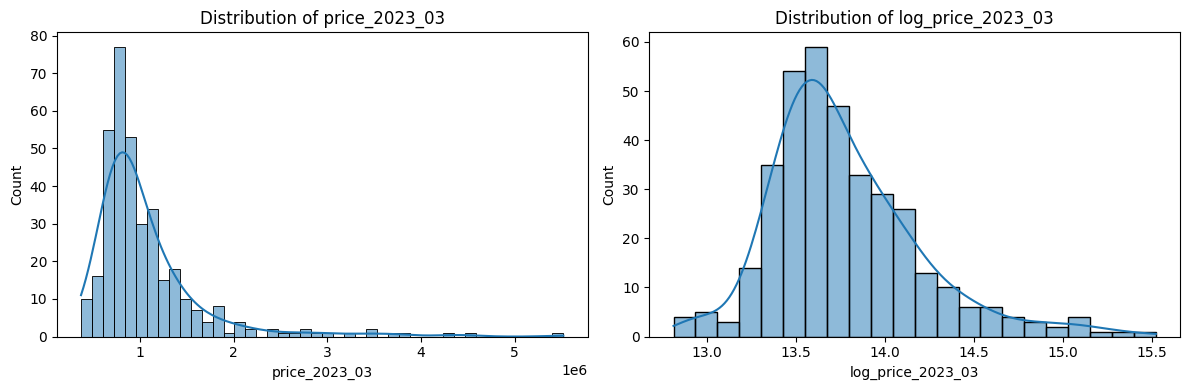

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for (idx, col) in enumerate(['price_2023_03', 'log_price_2023_03']):
    sns.histplot(data=merged_df, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.savefig('plots/price_distibutions.png')
plt.show()

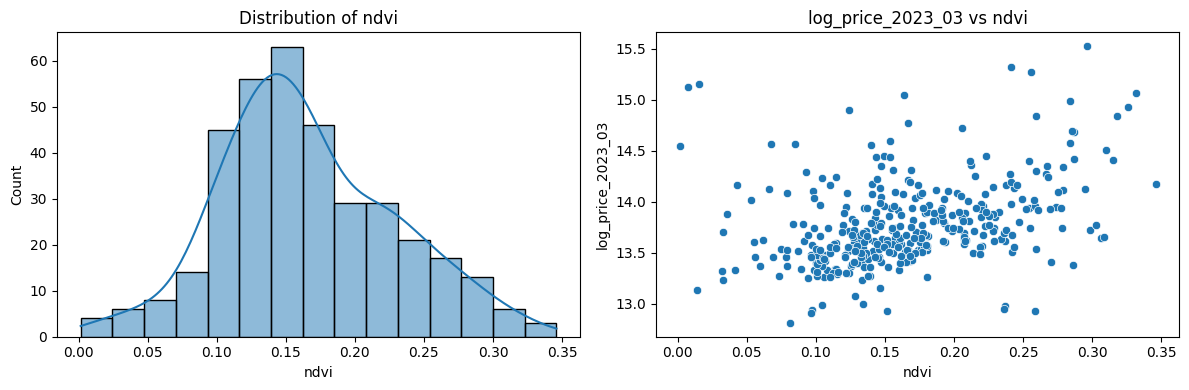

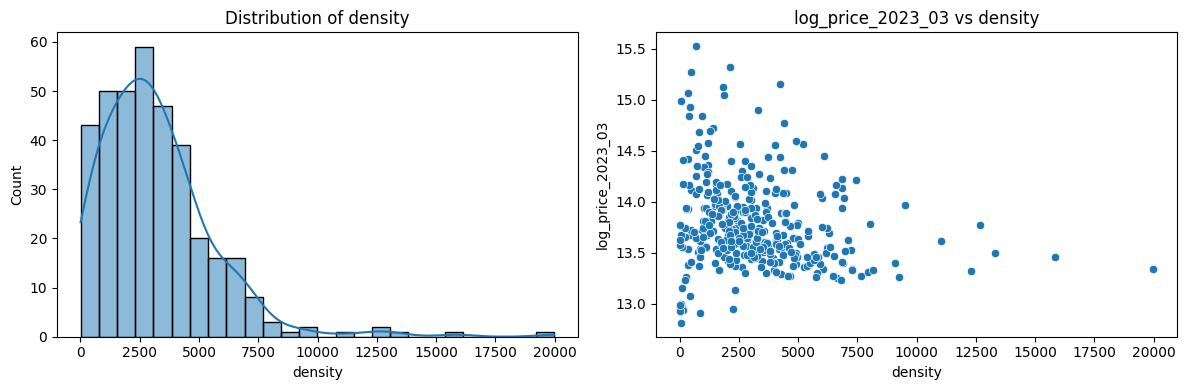

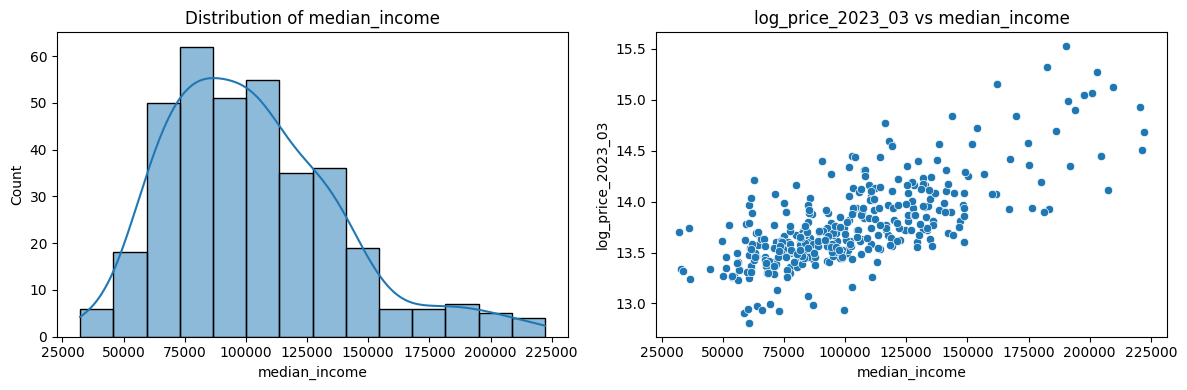

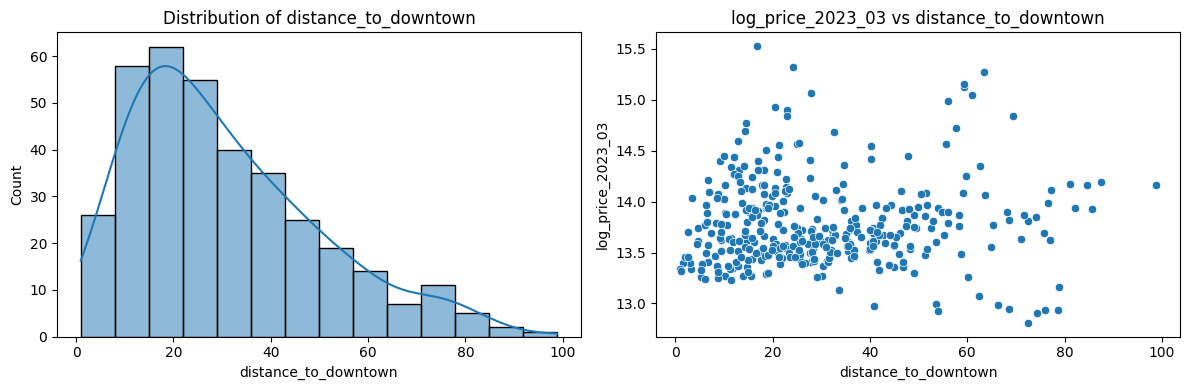

In [106]:
def plot_variables(data, target, features):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Left: distribution
        sns.histplot(data=data, x=feature, kde=True, ax=axes[0])
        axes[0].set_title(f"Distribution of {feature}")

        # Right: scatterplot with target
        sns.scatterplot(data=data, x=feature, y=target, ax=axes[1])
        axes[1].set_title(f"{target} vs {feature}")

        plt.tight_layout()
        plt.savefig(f'plots/{feature}_distributions.png')
        plt.show()

plot_variables(
    data=merged_df,
    target='log_price_2023_03',
    features=['ndvi', 'density', 'median_income', 'distance_to_downtown']
)

### Show the correlation between variables

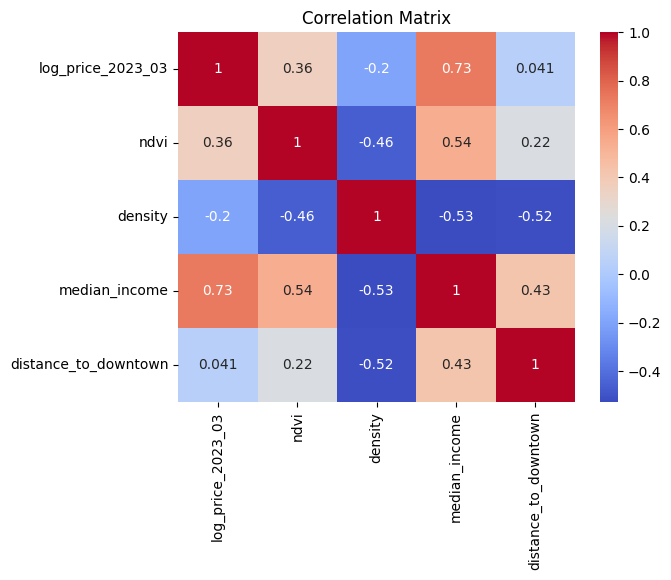

In [107]:
sns.heatmap(merged_df[['log_price_2023_03', 'ndvi', 'density', 'median_income', 'distance_to_downtown']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.savefig('plots/correlation.png')
plt.show()

### Plot the DataFrame into a map

Create a GeoDataFrame using shapely geometry and plot the two maps.

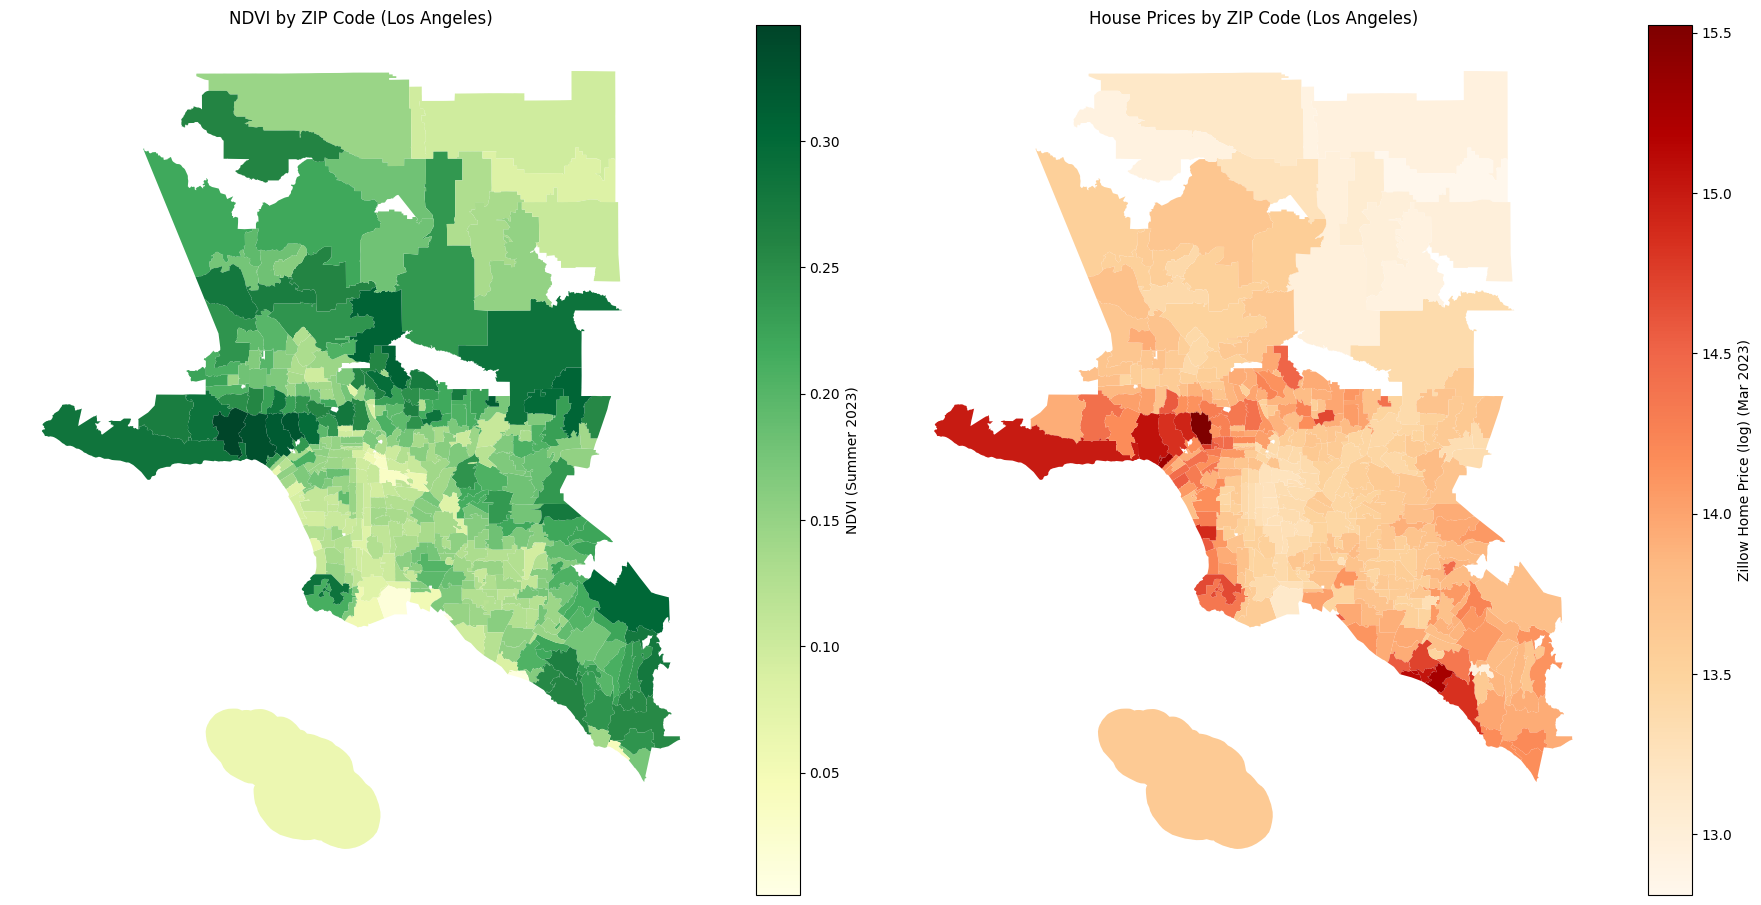

In [108]:
merged_df = pd.read_csv("data/zillow_ndvi_merged.csv")

# Convert WKT to shapely geometries
merged_df['.geo'] = merged_df['.geo'].apply(json.loads).apply(shape)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='.geo', crs="EPSG:4326")

fig, ax = plt.subplots(1, 2, figsize=(18, 9))

merged_gdf.plot(column='ndvi', cmap='YlGn', legend=True,
                legend_kwds={'label': "NDVI (Summer 2023)"},
                ax=ax[0])
ax[0].set_title("NDVI by ZIP Code (Los Angeles)")

merged_gdf.plot(column='log_price_2023_03', cmap='OrRd', legend=True,
                legend_kwds={'label': "Zillow Home Price (log) (Mar 2023)"},
                ax=ax[1])
ax[1].set_title("House Prices by ZIP Code (Los Angeles)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.savefig('plots/ndvi_hpi.png')
plt.show()

### Run model with House Pricing ~ NDVI + Density + Distance to Downtown

In [109]:
x_vars = ['ndvi', 'density', 'distance_to_downtown']
y_var = 'log_price_2023_03'

In [110]:
def ols(x_vars, y_var):
    X = merged_df[x_vars]
    X = sm.add_constant(X)
    y = merged_df[y_var]

    ols_model = sm.OLS(y, X).fit()
    regression_summary = ols_model.summary()
    print(regression_summary)

    return ols_model

### Spatial autocorrelation (Moran's I) for house prices
Caluclate the Moran's I and print it.

In [111]:
# Generate spatial weights using Queen contiguity
w = Queen.from_dataframe(merged_gdf)

# Compute Moran's I
moran = Moran(merged_gdf['log_price_2023_03'], w)

# Prepare results
moran_result = {
    "Moran's I": moran.I,
    "p-value": moran.p_sim
}

print(moran_result)

/tmp/ipykernel_7026/4129796575.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_gdf)


('WARNING: ', 351, ' is an island (no neighbors)')
{"Moran's I": 0.659690594601568, 'p-value': 0.001}


/home/leo/uni/geospatial/geospatial-analysis-project/.venv/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 351.
  warnings.warn(message)


### Compute spatial models

In [112]:
def sar(x_vars, y_var, w):
    # Define spatial weights
    w.transform = 'r'

    # Variables
    y = merged_df[y_var].values.reshape(-1, 1)
    X = merged_df[x_vars].values
    
    # Fit model
    lag_model = ML_Lag(y, X, w=w, name_y='log_price', name_x=x_vars, name_w='queen')

    # Print summary
    print(lag_model.summary)

    return lag_model

In [113]:
def sem(x_vars, y_var, w):
    # Define spatial weights
    w.transform = 'r'

    # Variables
    y = merged_df[y_var].values.reshape(-1, 1)
    X = merged_df[x_vars].values
    
    # Fit spatial error model
    error_model = ML_Error(y, X, w=w, name_y='log_price', name_x=x_vars, name_w='queen')

    print(error_model.summary)

    return error_model

In [114]:
def comparison(ols_model, lag_model, error_model, w):
    if ols_model is None or lag_model is None or error_model is None:
        raise ValueError("One or more models are None. Check that all models were fitted correctly.")

    comparison_table = {
        "Model": ["OLS", "SAR", "SEM"],
        "R-squared / pseudo R²": [
            f"{getattr(ols_model, 'rsquared', 0):.4f}",
            f"{getattr(lag_model, 'pr2', 0):.4f}",
            f"{getattr(error_model, 'pr2', 0):.4f}"
        ],
        "Log-Likelihood": [
            f"{getattr(ols_model, 'llf', 0):.2f}",
            f"{getattr(lag_model, 'logll', 0):.2f}",
            f"{getattr(error_model, 'logll', 0):.2f}"
        ],
        "AIC": [
            f"{getattr(ols_model, 'aic', 0):.2f}",
            f"{getattr(lag_model, 'aic', 0):.2f}",
            f"{getattr(error_model, 'aic', 0):.2f}"
        ],
        "Spatial parameter (ρ or λ)": [
            "—",
            f"{getattr(lag_model, 'rho', 0):.4f}",
            f"{getattr(error_model, 'lambda_', 0):.4f}"
        ],
        "P-value (ρ or λ)": [
            "—",
            f"{lag_model.std_err[-1]:.4f}" if hasattr(lag_model, 'std_err') else "—",
            f"{error_model.std_err[-1]:.4f}" if hasattr(error_model, 'std_err') else "—"
        ]
    }

    comparison_df = pd.DataFrame(comparison_table)

    # Moran's I on residuals
    moran_lag = Moran(lag_model.u, w)
    moran_error = Moran(error_model.u, w)

    moran_df = pd.DataFrame({
        "Model": ["SAR", "SEM"],
        "Moran's I": [moran_lag.I, moran_error.I],
        "P-value": [moran_lag.p_sim, moran_error.p_sim]
    })

    display(comparison_df)
    display(moran_df)

### Fit the models and compare the results
The OLS model is fitted against spatial models (SAR and SEM). Results are shown for comparison in a table.

In [115]:
ols_model = ols(x_vars=x_vars, y_var=y_var)
lag_model = sar(x_vars=x_vars, y_var=y_var, w=w)
error_model = sem(x_vars=x_vars, y_var=y_var, w=w)

comparison(ols_model=ols_model, lag_model=lag_model, error_model=error_model, w=w)

/home/leo/uni/geospatial/geospatial-analysis-project/.venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


                            OLS Regression Results                            
Dep. Variable:      log_price_2023_03   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     18.61
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           3.08e-11
Time:                        17:25:32   Log-Likelihood:                -174.71
No. Observations:                 360   AIC:                             357.4
Df Residuals:                     356   BIC:                             373.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.4902 

,Model,R-squared / pseudo R²,Log-Likelihood,AIC,Spatial parameter (ρ or λ),P-value (ρ or λ)
0,OLS,0.1356,-174.71,357.42,—,—
1,SAR,0.2284,-155.12,320.25,0.1598,0.0260
2,SEM,0.1005,-1.71,11.42,0.0000,0.0300


,Model,Moran's I,P-value
0,SAR,0.547821,0.001
1,SEM,0.718781,0.001


### Run models with House Pricing ~ NDVI + Density + Distance to Downtown + Median Income
Now also the `median_income` variable is added to the model.

In [116]:
x_vars = ['ndvi', 'density', 'distance_to_downtown', 'median_income']

The models are fitted again with the new set of variables.

In [117]:
ols_model_income = ols(x_vars=x_vars, y_var=y_var)
lag_model_income = sar(x_vars=x_vars, y_var=y_var, w=w)
error_model_income = sem(x_vars=x_vars, y_var=y_var, w=w)

comparison(ols_model=ols_model, lag_model=lag_model, error_model=error_model, w=w)

                            OLS Regression Results                            
Dep. Variable:      log_price_2023_03   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     154.7
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           1.92e-76
Time:                        17:25:33   Log-Likelihood:                -19.337
No. Observations:                 360   AIC:                             48.67
Df Residuals:                     355   BIC:                             68.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.7673 

/home/leo/uni/geospatial/geospatial-analysis-project/.venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


,Model,R-squared / pseudo R²,Log-Likelihood,AIC,Spatial parameter (ρ or λ),P-value (ρ or λ)
0,OLS,0.1356,-174.71,357.42,—,—
1,SAR,0.2284,-155.12,320.25,0.1598,0.0260
2,SEM,0.1005,-1.71,11.42,0.0000,0.0300


,Model,Moran's I,P-value
0,SAR,0.547821,0.001
1,SEM,0.718781,0.001


### Plots of the resulting models

Add the required data to the GeoDataFrame.

In [118]:
merged_gdf['predicted_ols'] = ols_model_income.fittedvalues
merged_gdf['predicted_sar'] = lag_model_income.predy.flatten()
merged_gdf['residuals_sar'] = lag_model_income.u.flatten()

### Show the strength of the predictions.
Comparing the predictions of the OLS model with the ones of the SAR model.

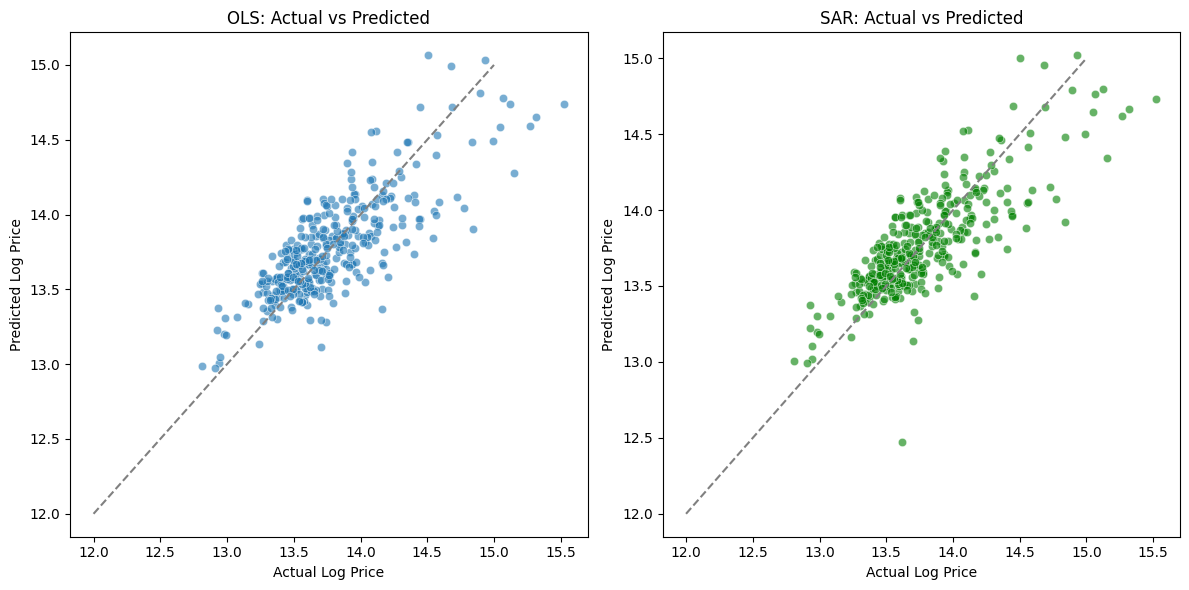

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# OLS: Actual vs Predicted
sns.scatterplot(
    x=merged_gdf['log_price_2023_03'],
    y=merged_gdf['predicted_ols'],
    ax=axes[0],
    alpha=0.6
)
axes[0].plot([12, 15], [12, 15], '--', color='gray')
axes[0].set_title("OLS: Actual vs Predicted")
axes[0].set_xlabel("Actual Log Price")
axes[0].set_ylabel("Predicted Log Price")

# SAR: Actual vs Predicted
sns.scatterplot(
    x=merged_gdf['log_price_2023_03'],
    y=merged_gdf['predicted_sar'],
    ax=axes[1],
    alpha=0.6,
    color='green'
)
axes[1].plot([12, 15], [12, 15], '--', color='gray')
axes[1].set_title("SAR: Actual vs Predicted")
axes[1].set_xlabel("Actual Log Price")
axes[1].set_ylabel("Predicted Log Price")

plt.tight_layout()
plt.savefig('plots/actual_predicted.png')
plt.show()

### Show the residuals of the SAR model

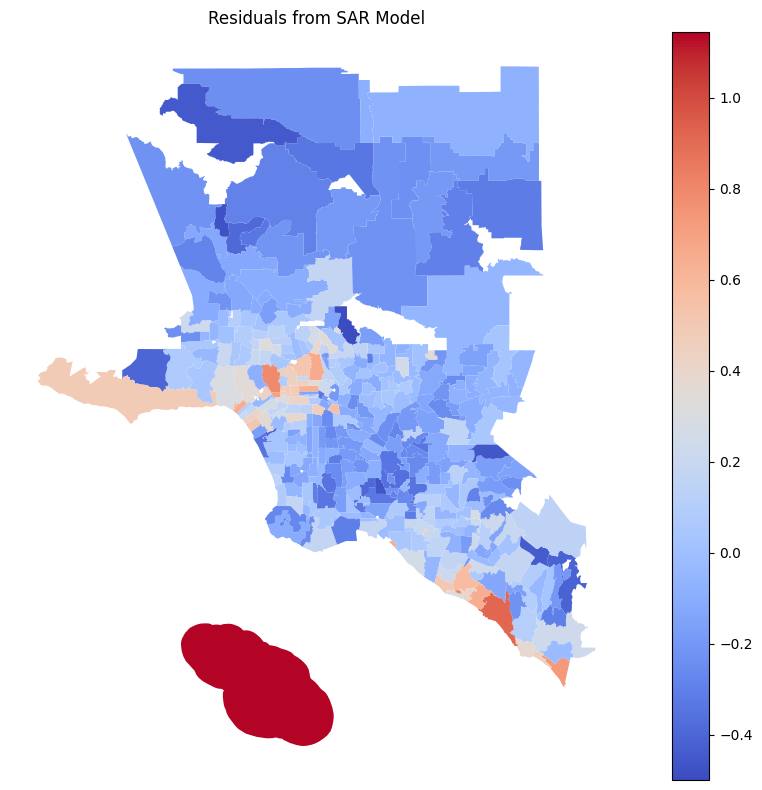

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
merged_gdf.plot(column='residuals_sar', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Residuals from SAR Model")
ax.axis('off')
plt.tight_layout()
plt.savefig('plots/sar_residuals.png')
plt.show()

### Plot the effect of the NDVI on the House Prices, including the Median Income

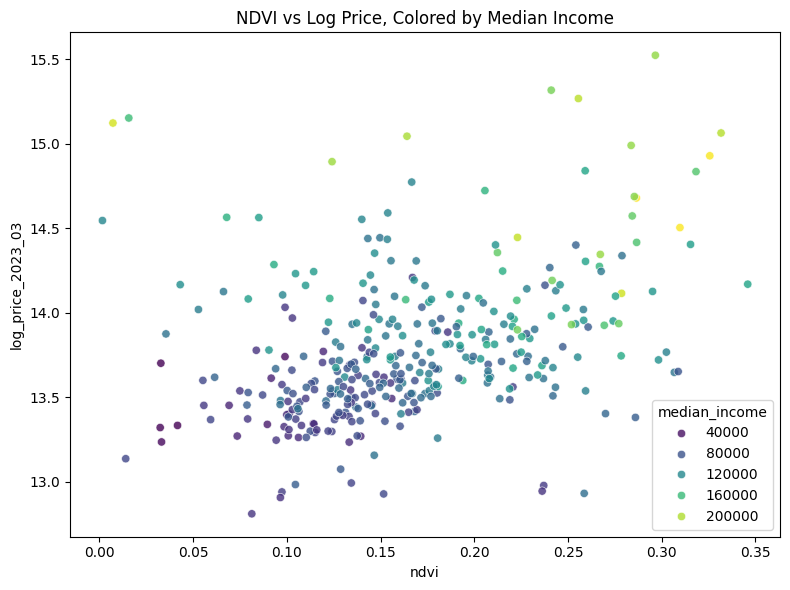

In [121]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df,
    x='ndvi',
    y='log_price_2023_03',
    hue='median_income',
    palette='viridis',
    alpha=0.8
)
plt.title("NDVI vs Log Price, Colored by Median Income")
plt.tight_layout()
plt.savefig('plots/ndvi_price_income.png')
plt.show()